<a href="https://colab.research.google.com/github/vineetshah53/ClimateChange/blob/main/Final_ClimateChange_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Setting Up

import os # import OS module to interact with Operating System
import datetime # import module to manipulate date and time

import IPython # import ipython command shell
import IPython.display # import display tools

import matplotlib as mpl # import matplot library for visualization
import matplotlib.pyplot as plt # import library to plot timeseries data

import numpy as np # import numpy library for mathematical operations
import pandas as pd # import pandas library to process timeseries data
import seaborn as sns # import seaborn library to process statistical graphics
import tensorflow as tf # import tensorflow 
from tensorflow.keras import layers

from tensorflow import keras # import Keras to build and summarize the model
import plotly.express as px # import plotly.express to create graphs

from sklearn.preprocessing import MinMaxScaler # to normalize training data

mpl.rcParams['figure.figsize'] = (8,6) # setting the size of figures plotted using mpl
mpl.rcParams['axes.grid'] = False # setting not to show gridlines on plots


In [ ]:
# Importing Data from drive

from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['Train.csv']))


Saving Train.csv to Train (3).csv


In [ ]:
# Check Training Data

df.head()


,Years,CO2EQ,CO2,CH4,N2O,Temp_Anomaly
0,1850,284.47783,284.725,790.97924,275.42506,-0.05
1,1851,284.67850,284.875,792.25000,275.50000,0.11
2,1852,284.49410,285.000,793.75000,275.60000,0.10
3,1853,284.25420,285.125,795.25000,275.70000,0.06
4,1854,284.31698,285.275,796.75000,275.80000,0.08


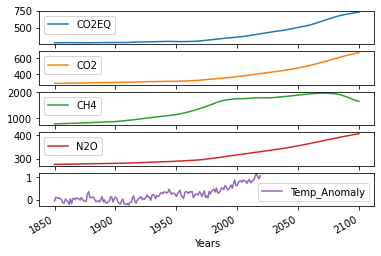

In [ ]:
# Visualizing the data

plot_cols = ['CO2EQ', 'CO2', 'CH4', 'N2O','Temp_Anomaly']
plot_features = df[plot_cols]
plot_features.index = df['Years']
_ = plot_features.plot(subplots=True)

In [ ]:
# Splitting the dataframe for Training and Validation dataframes

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.6)] 
val_df = df[int(n*0.6):int(n*0.68)] 
test_df = df[int(n*0.68):int(n)]

num_features = df.shape[1]

In [ ]:
# check shape of training and validation dataframes

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(150, 6)
(20, 6)
(81, 6)


In [ ]:
# Scaling the  data between 0 and 1 using minmaxscaler from keras
# LSTM works better with scaled data

scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train_df) 
val = scaler.transform(val_df) 
test = scaler.transform(test_df)

In [ ]:
# split data into input features and targets

train_x, train_y = train[:,:-1], train[:,-1] 
val_x, val_y = val[:,:-1], val[:,-1]
test_x, test_y = test[:,:-1], test[:,-1]

In [ ]:
# reshape train_x and test_x for the model

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))

val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

(150, 1, 5) (150,) (20, 1, 5) (20,) (81, 1, 5) (81,)


In [ ]:
# building the LSTM model using keras

def build_model(train_x):
    inputs = keras.layers.Input(shape = (train_x.shape[1], train_x.shape[2]))
    x = keras.layers.LSTM(50,return_sequences =  True)(inputs) 
    x = keras.layers.Dropout(0.3)(x) 
    x = keras.layers.LSTM(50, return_sequences = True)(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.LSTM(50)(x)
    outputs = keras.layers.Dense(1, activation = 'linear')(x) 

    model = keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer = 'adam', loss = "mse") 
    return model

model = build_model(train_x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 5)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 50)             11200     
_________________________________________________________________
dropout (Dropout)            (None, 1, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51    

In [ ]:
# fitting the model with model.fit without shuffling

process = model.fit(train_x, train_y, epochs = 50, batch_size = 72, validation_data = (val_x, val_y), shuffle = False)

In [ ]:
# plotting the loss and validation loss against epochs

def plot_process(process):
    plt.plot(process.history['loss'], label='train')
    plt.plot(process.history['val_loss'], label='validation')
    plt.grid()
    plt.legend()
    plt.show()

plot_process(process)

In [ ]:
def prediction(model,test_x,train_x, df):
    # Predict using the model
    predict =  model.predict(test_x)

    # Reshape test_x and train_x for visualization and reshaping to original shape
    test_x = test_x.reshape((test_x.shape[0], test_x.shape[2]))
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[2]))

    # Concatenate test_x with predicted value
    predict_ = np.concatenate((test_x, predict),axis = 1)

    # Inverse-scaling to get the real values, removing min max scaler
    predict_ = scaler.inverse_transform(predict_)
    original_ = scaler.inverse_transform(test)

    # Create dataframe to store the predicted and original values
    pred = pd.DataFrame()
    pred['Years'] = df['Years'][-test_x.shape[0]:]
    pred['Original'] = original_[:,-1] 
    pred['Predicted'] = predict_[:,-1] 

    
    # Create dataframe for visualization
    df = df[['Years','Temp_Anomaly']][:-test_x.shape[0]]
    df.columns = ['Years','Original']
    original = df.append(pred[['Years','Original']])
    df.columns = ['Years','Predicted']
    predicted = df.append(pred[['Years','Predicted']])
    original = original.merge(predicted, left_on = 'Years',right_on = 'Years')
    return pred, original

pred, original = prediction(model, test_x, train_x, df)

In [ ]:


# Plotting the predicted values

def plot(df):
    fig = px.line(title = 'Temperature Prediction')
    fig.add_scatter(x = df['Years'], y = df['Original'], name = 'Recorded Temperature Anomaly', opacity = 0.7)
    fig.add_scatter(x = df['Years'], y = df['Predicted'], name = 'Predicted Temperature Anomaly', opacity = 0.5)
    fig.show()

plot(original)